Data Analysis (EDA) and Model Train And Model Evaluation

 Step 1: Load Required Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import torch


Step 2: Define Transformations

In [ ]:

# Mean & Standard Deviation (Normalization)
# These values represent the average pixel intensity (mean) and variation (std) across all images in CIFAR-10.
# CIFAR-10 images have 3 color channels (RGB), so mean & std are tuples of 3 values (one for each channel)
# Why Normalize?
# Neural networks perform better when inputs are in a standard range (e.g., close to 0).
# The raw pixel values (0 to 255) are converted to a standard distribution with mean 0 and variance 1 using:

# Compute Mean and Std for Normalization
mean = (0.4914, 0.4822, 0.4465)  # Precomputed CIFAR-10 Mean
std = (0.247, 0.243, 0.261)  # Precomputed CIFAR-10 Std

# Define Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.RandomRotation(15),  # Rotate images randomly
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Change brightness/contrast
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean, std)  # Normalize images
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean, std)  # Normalize
])

 Step 3: Load CIFAR-10 Dataset

In [15]:
# Load Dataset with Transformations
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Class Names
classes = trainset.classes  # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Class names:- {classes}")
print(f"Training Samples: {len(trainset)}")
print(f"Testing Samples: {len(testset)}")


Class names:- ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training Samples: 50000
Testing Samples: 10000


 Step 4: Exploratory Data Analysis (EDA)

1. Visualize Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.029273970029834e-09..1.0000000339984894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.029273970029834e-09..0.9999999868392944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.029273970029834e-09..1.0000000339984894].


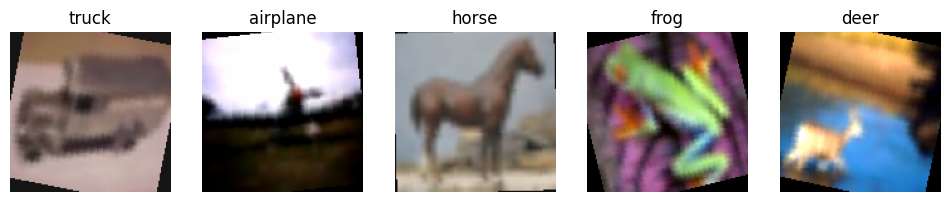

In [16]:
# Display images
def imshow(images, labels):
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        image = images[i].numpy().transpose(1, 2, 0)  # Convert to numpy
        image = (image * std) + mean  # Denormalize
        axes[i].imshow(image)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

# Get a batch of images
dataiter = iter(DataLoader(trainset, batch_size=5, shuffle=True))
images, labels = next(dataiter)
imshow(images, labels)



2. Class Distribution

C:\Users\dellm\AppData\Local\Temp\ipykernel_23788\2084227091.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


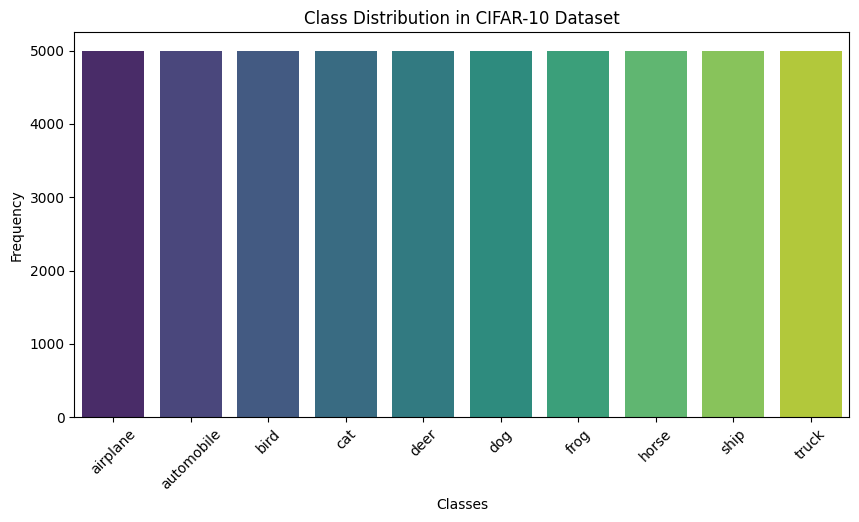

In [17]:
import pandas as pd

# Get class counts
train_labels = [trainset.targets[i] for i in range(len(trainset))]
class_counts = pd.Series(train_labels).value_counts()

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution in CIFAR-10 Dataset")
plt.show()


Step 5: Split into Training, Validation, and Testing

In [ ]:
# Split training dataset (80% train, 10% validation)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_data, val_data = random_split(trainset, [train_size, val_size])


# ✅ Add `num_workers=4` for faster GPU data loading
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


print(f"Train Samples: {len(train_data)}")
print(f"Validation Samples: {len(val_data)}")
print(f"Test Samples: {len(testset)}")

Train Samples: 40000
Validation Samples: 10000
Test Samples: 10000


Part-2 Model Training And Evalution Methods

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet18_Weights

# ✅ Load Pretrained ResNet-18 with Correct Weights
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Fix for pretrained=True

# ✅ Modify the final layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
num_classes = len(trainset.classes)  # Dynamically set number of classes
model.fc = nn.Linear(num_ftrs, num_classes)

# ✅ Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(device)
print(model)  # Print model architecture


Define Loss Function, Optimizer & Scheduler

In [32]:
import torch.optim as optim

# ✅ Define Loss Function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# ✅ Define Optimizer (Adam optimizer for better convergence)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Define Learning Rate Scheduler (Reduces LR after every 5 epochs)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


Check System configuration ans Train the Model

In [26]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "No GPU detected")
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
print("GPU Memory Allocated:", torch.cuda.memory_allocated(0) / 1024**2, "MB")
print("GPU Memory Cached:", torch.cuda.memory_reserved(0) / 1024**2, "MB")


PyTorch Version: 2.6.0+cu126
CUDA Available: True
Current Device: 0
GPU Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU Memory Allocated: 209.68994140625 MB
GPU Memory Cached: 506.0 MB


In [34]:
import sys

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # ✅ Print batch progress
            if (batch_idx + 1) % 10 == 0:  # Show progress every 10 batches
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/(batch_idx+1):.4f}, Accuracy: {100 * correct / total:.2f}%", flush=True)
                sys.stdout.flush()  # Force Jupyter Notebook to display output immediately

        scheduler.step()  # Adjust learning rate

        # ✅ Print epoch summary
        print(f"\n✅ Epoch {epoch+1}/{epochs} Completed! Avg Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%\n", flush=True)


# ✅ Start Training
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)


Epoch [1/10], Batch [10/1250], Loss: 2.0367, Accuracy: 34.38%
Epoch [1/10], Batch [20/1250], Loss: 2.0205, Accuracy: 36.09%
Epoch [1/10], Batch [30/1250], Loss: 1.8969, Accuracy: 39.27%
Epoch [1/10], Batch [40/1250], Loss: 1.7915, Accuracy: 41.25%
Epoch [1/10], Batch [50/1250], Loss: 1.6821, Accuracy: 43.31%
Epoch [1/10], Batch [60/1250], Loss: 1.6139, Accuracy: 45.52%
Epoch [1/10], Batch [70/1250], Loss: 1.5474, Accuracy: 47.63%
Epoch [1/10], Batch [80/1250], Loss: 1.4939, Accuracy: 49.18%
Epoch [1/10], Batch [90/1250], Loss: 1.4331, Accuracy: 50.97%
Epoch [1/10], Batch [100/1250], Loss: 1.3934, Accuracy: 52.50%
Epoch [1/10], Batch [110/1250], Loss: 1.3730, Accuracy: 53.18%
Epoch [1/10], Batch [120/1250], Loss: 1.3462, Accuracy: 54.01%
Epoch [1/10], Batch [130/1250], Loss: 1.3188, Accuracy: 54.83%
Epoch [1/10], Batch [140/1250], Loss: 1.2986, Accuracy: 55.76%
Epoch [1/10], Batch [150/1250], Loss: 1.2865, Accuracy: 56.23%
Epoch [1/10], Batch [160/1250], Loss: 1.2648, Accuracy: 56.93%
E

In [ ]:
# ✅ Save the trained model
torch.save(model.state_dict(), "model/custom_resnet18.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
# ✅ Load Model
model.load_state_dict(torch.load("model/custom_resnet18.pth"))
model.eval()  # Set model to evaluation mode
print("Model loaded successfully!")


Model loaded successfully!


Model Evaluation


✅ Accuracy: 0.9174
✅ Precision: 0.9176
✅ Recall: 0.9174
✅ F1 Score: 0.9172

Classification Report:
               precision    recall  f1-score   support

    airplane       0.92      0.90      0.91      1000
  automobile       0.94      0.96      0.95      1000
        bird       0.90      0.91      0.90      1000
         cat       0.86      0.83      0.84      1000
        deer       0.94      0.90      0.92      1000
         dog       0.88      0.88      0.88      1000
        frog       0.90      0.97      0.93      1000
       horse       0.96      0.94      0.95      1000
        ship       0.92      0.96      0.94      1000
       truck       0.96      0.93      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



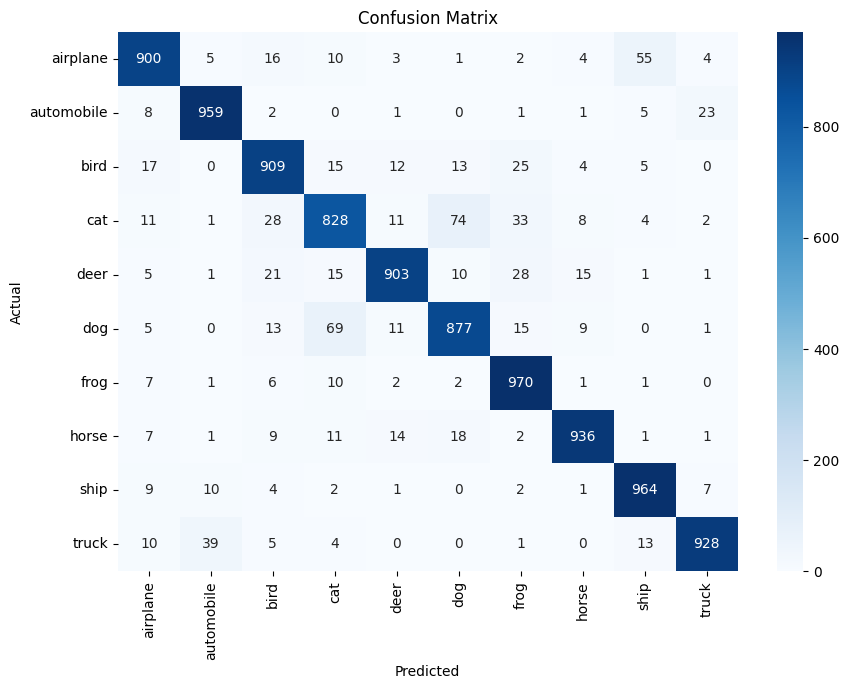

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_loader, classes):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())  # Store actual labels
            y_pred.extend(predicted.cpu().numpy())  # Store predicted labels

    # ✅ Calculate Evaluation Metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes))

    # ✅ Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# ✅ Run Model Evaluation
evaluate_model(model, test_loader, classes)


Save the Model in Different Formats (Save In Pikle File)

In [ ]:
import pickle

# Save the entire model (including architecture)
with open("model/custom_resnet18.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as Pickle (.pkl) format!")


Model saved as Pickle (.pkl) format!
